In [1]:
pdf_path = './data/UniversScience/revue-decouverte/decouverte_436.pdf'


In [2]:
from pdf2image import convert_from_path
pages = convert_from_path(pdf_path)

In [3]:
from transformers import LayoutLMForTokenClassification, LayoutLMv3Processor, AutoTokenizer
model = LayoutLMForTokenClassification.from_pretrained("Kwan0/layoutlmv3-base-finetune-DocLayNet-100k")
processor = LayoutLMv3Processor.from_pretrained("Kwan0/layoutlmv3-base-finetune-DocLayNet-100k")
tokenizer = AutoTokenizer.from_pretrained("Kwan0/layoutlmv3-base-finetune-DocLayNet-100k")


You are using a model of type layoutlmv3 to instantiate a model of type layoutlm. This is not supported for all configurations of models and can yield errors.
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at Kwan0/layoutlmv3-base-finetune-DocLayNet-100k and are newly initialized: ['classifier.bias', 'classifier.weight', 'layoutlm.embeddings.LayerNorm.bias', 'layoutlm.embeddings.LayerNorm.weight', 'layoutlm.embeddings.h_position_embeddings.weight', 'layoutlm.embeddings.position_embeddings.weight', 'layoutlm.embeddings.token_type_embeddings.weight', 'layoutlm.embeddings.w_position_embeddings.weight', 'layoutlm.embeddings.word_embeddings.weight', 'layoutlm.embeddings.x_position_embeddings.weight', 'layoutlm.embeddings.y_position_embeddings.weight', 'layoutlm.encoder.layer.0.attention.output.LayerNorm.bias', 'layoutlm.encoder.layer.0.attention.output.LayerNorm.weight', 'layoutlm.encoder.layer.0.attention.output.dense.bias', 'layoutlm.encoder.

[3, 3, 3, 3, 9, 9, 9, 4, 9, 9, 1, 1, 1, 1, 1, 9, 3, 4, 1, 1, 1, 9, 9, 9, 9, 3, 9, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 9, 2, 1, 1, 3, 9, 1, 9, 9, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 9, 6, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 10, 10, 10, 4, 3, 1, 1, 10, 10, 10, 1, 10, 3, 3, 3, 3, 3, 3, 8, 0, 10, 10, 10, 1, 10, 3, 3, 3, 7, 3, 3, 3, 1, 3, 1, 1, 3, 3, 9, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 0, 8, 3, 9, 0, 9, 3, 3, 3, 3, 7, 0, 7, 7, 1, 10, 10, 10, 10, 3, 3, 1, 1, 10, 1, 1, 3, 3, 3, 3, 3, 3, 3, 7, 3, 1, 1, 1, 1, 3, 10, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 0, 10, 3, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 10, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 8, 1, 5, 6, 10, 10, 10, 10, 6, 5, 9, 5, 3, 3, 9, 5, 9, 6, 9, 1, 3, 1, 0, 5, 5, 6, 1, 9, 6, 

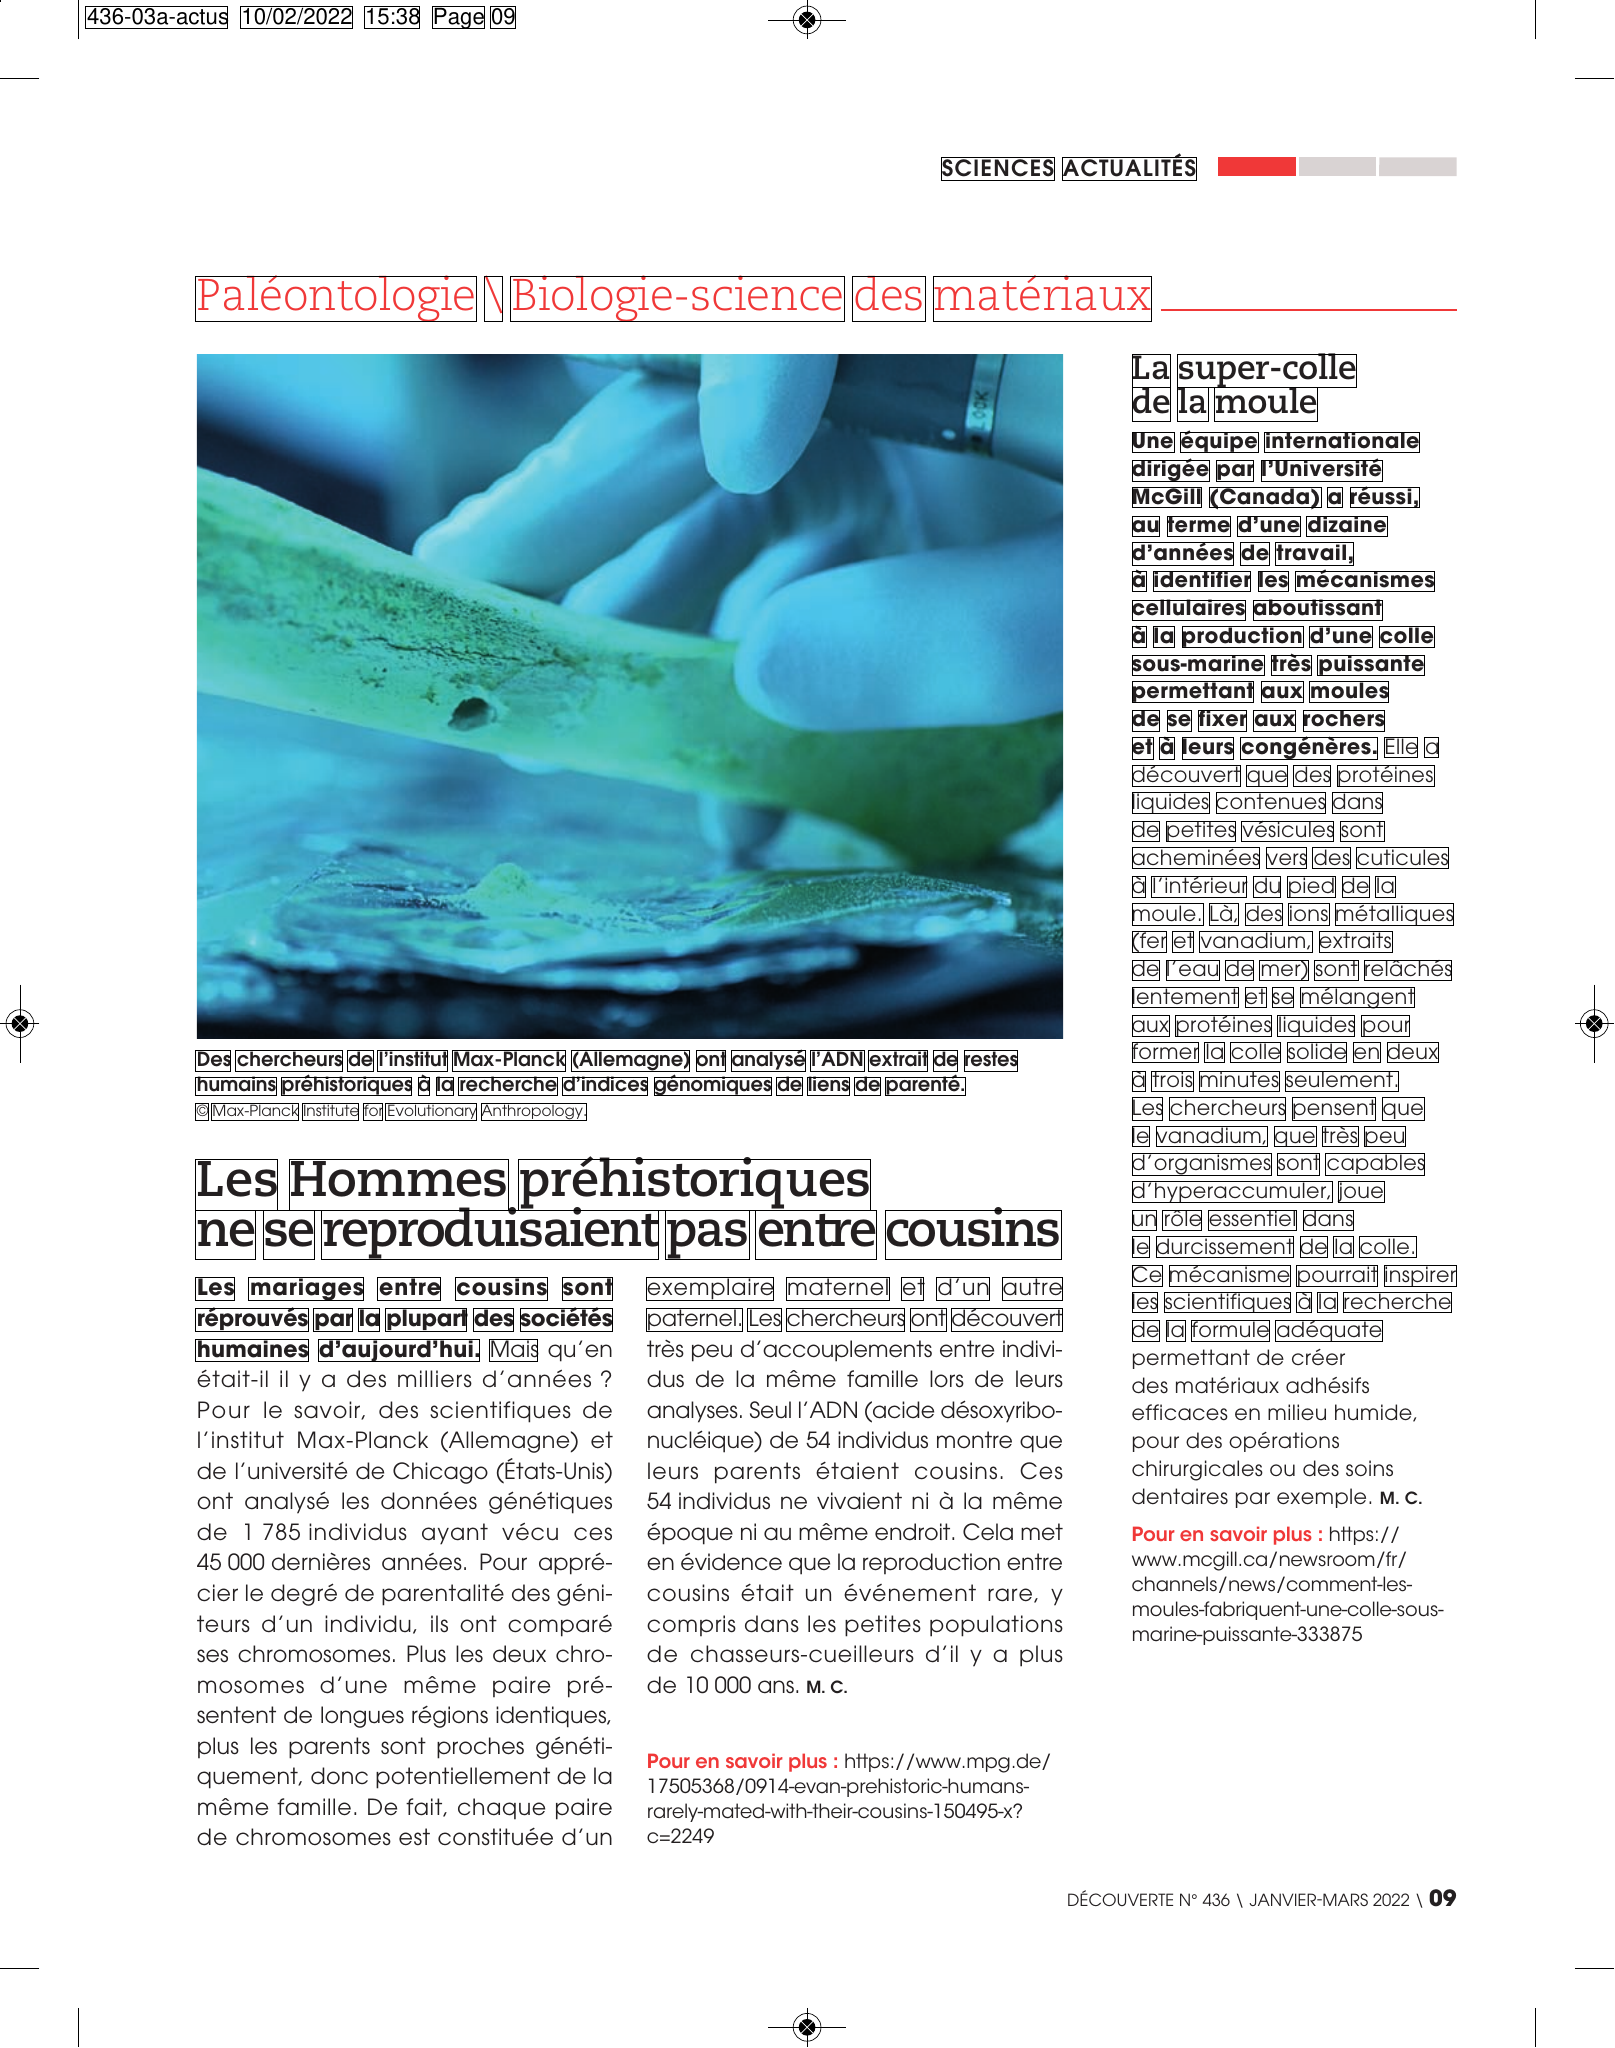

In [22]:
from PIL import Image, ImageDraw, ImageFont
import pdfplumber

def unnormalize_box(bbox, width, height, usingOCR):
    if usingOCR == True:
        return [
            width * (bbox[0] / 1000),
            height * (bbox[1] / 1000),
            width * (bbox[2] / 1000),
            height * (bbox[3] / 1000),
        ]
    else: 
        return [
           (bbox[0] / (224/1025.)),
           (bbox[1] / (224/1025.)),
           (bbox[2] / (224/1025.)),
           (bbox[3] / (224/1025.)),
        ]    

def normalize_box(bbox, width, height, usingOCR):
    if usingOCR:
        return [
            int(1000 * (bbox[0] / width)),
            int(1000 * (bbox[1] / height)),
            int(1000 * (bbox[2] / width)),
            int(1000 * (bbox[3] / height)),
        ]
    else:
        return [
            int(bbox[0] * (224/1025.)),
            int(bbox[1] * (224/1025.)),
            int(bbox[2] * (224/1025.)),
            int(bbox[3] * (224/1025.)),
        ]
    
def extract_text_and_boxes(pdf_path, page_number=0, usingOCR=False):
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[page_number]
        
        # Extract text
        # text = page.extract_text()
        
        # Extract word boxes
        words = page.extract_words()
        text = [word['text'] for word in words]
        boxes = [normalize_box([word['x0'], word['top'], word['x1'], word['bottom']], page.width, page.height, usingOCR) for word in words]
    
    return text, boxes

label2color = {
    "Caption": "brown",
    "Footnote": "gray",
    "Formula": "magenta",
    "List-Item": "purple",
    "Page-Footer": "black",
    "Page-Header": "black",
    "Picture": "orange",
    "Section-Header": "yellow",
    "Table": "green",
    "Text": "red",
    "Title": "blue",

}

# draw results onto the image
def draw_boxes(image, boxes, predictions, usingOCR):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height, usingOCR) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        draw.rectangle(box, outline="black")
        # draw.rectangle(box, outline=label2color[prediction])
        # draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(pages, page_number, model=model, processor=processor, output_image=True, usingOCR=True):
    image = pages[page_number].convert("RGB")
    words, boxes = extract_text_and_boxes(pdf_path, page_number, usingOCR)

    # words = dataset['test'][i]['words']
    # boxes_float = dataset['test'][i]['bboxes']
    boxes = [[round(b[0]), round(b[1]), round(b[2]), round(b[3])] for b in boxes]
    # tags = dataset['test'][i]['tags']

    encoding = processor(
        image,
        words,
        boxes=boxes,
        # word_labels=tags,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    del encoding["pixel_values"]


    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [prediction for prediction in predictions]
    print(labels)
    # labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels, usingOCR)
    else:
        return labels


run_inference(pages, 10, model, processor, output_image=True, usingOCR=True)